In [19]:
#%% Imports
import os
import shutil
import nibabel as nib
import numpy as np
import random
import pickle
import matplotlib.pyplot as plt
from glob import glob
from scipy import ndimage
from nilearn.image import resample_to_img, resample_img
from nilearn.masking import compute_background_mask, compute_epi_mask
from nilearn.plotting import plot_roi, plot_epi
from scipy.spatial.distance import directed_hausdorff
from nipype.algorithms.metrics import Distance
from sklearn.metrics import roc_curve, auc
from scipy import interp

In [20]:
# Set working directory
os.chdir('/home/uziel/DISS')
# Set root of models to be post-processed
root = "./milestones_4"
model_variant = 'DM_V0_[0-4]' # choose model variant. Eg. "DM_V0_[0-4]".
tmp = model_variant.split('_')
if len(tmp) == 3:
    model_name = tmp[1]
elif len(tmp) == 4:
    model_name = tmp[1] + '_' + tmp[2]
else:
    model_name = tmp[1] + '_' + tmp[2] + '_' + tmp[3]
trained_models = sorted(glob(os.path.join(root, model_variant)))

In [21]:
def get_test_metrics(original_label, predicted_label, mask_img):
    original_data = nib.load(original_label).get_data()
    predicted_data = nib.load(predicted_label).get_data()
    mask_data = mask_img.get_data() # use mask to limit results to the brain
    
    metrics = {}
    
    # True positive
    metrics['TP'] = float(np.sum((((predicted_data == 1).astype(int) +
                                   (original_data == 1).astype(int)) * mask_data) == 2))
    
    # True negative
    metrics['TN'] = float(np.sum((((predicted_data == 0).astype(int) +
                                   (original_data == 0).astype(int)) * mask_data) == 2))
    
    # False positive (all 1's in predicted minus original 1's)
    metrics['FP'] = float(np.sum((((predicted_data == 1).astype(int) -
                                   (original_data == 1).astype(int)) * mask_data) == 1))
    
    # False negative
    metrics['FN'] = float(np.sum((((predicted_data == 1).astype(int) -
                                   (original_data == 1).astype(int)) * mask_data) == -1))

    # True positive rate (Sensitivity, Recall)
    metrics['TPR'] = metrics['TP'] / (metrics['TP'] + metrics['FN'])  
    
    # True negative rate (Specificity)
    metrics['TNR'] = metrics['TN'] / (metrics['TN'] + metrics['FP'])
    
    # Positive predictive value (Precision)
    metrics['PPV'] = metrics['TP'] / (metrics['TP'] + metrics['FP'])
    
    # Negative predictive value
    metrics['NPV'] = metrics['TN'] / (metrics['TN'] + metrics['FN'])
    
    # False negative rate (Miss rate)
    metrics['FNR'] = 1 -  metrics['TPR']
    
    # False positive rate (Fall-out)
    metrics['FPR'] = 1 - metrics['TNR']
    
    # False discovery rate
    metrics['FDR'] = 1 - metrics['PPV']
    
    # False omission rate
    metrics['FOR'] = 1 - metrics['NPV']
    
    # Accuracy
    metrics['ACC'] = (metrics['TP'] + metrics['TN']) / \
                                (metrics['TP'] + 
                                 metrics['TN'] + 
                                 metrics['FP'] + 
                                 metrics['FN'])
    
    # F1 Score (also known as DSC, Sørensen–Dice coefficient, ...)
    #metrics['F1S'] = 2 * (metrics['PPV'] * metrics['TPR']) / \
    #                                (metrics['PPV'] + metrics['TPR'])
    metrics['F1S'] = (2*metrics['TP']) / (2*metrics['TP'] + metrics['FP'] + metrics['FN'])
    
    # Matthews correlation coefficient
    # The MCC can be more appropriate when negatives actually mean something,
    # and can be more useful in other ways.
    metrics['MCC'] = metrics['TP'] * metrics['TN'] - \
                                metrics['FP'] * metrics['FN'] / \
                                np.sqrt((metrics['TP'] + metrics['FP']) *
                                       (metrics['TP'] + metrics['FN']) *
                                       (metrics['TN'] + metrics['FP']) *
                                       (metrics['TN'] + metrics['FN']))
    
    # Compute Hausdorff distance
    D = Distance()
    metrics['HD'] = D._eucl_max(nib.load(original_label), nib.load(predicted_label))
    
    # Compute Jaccard index
    metrics['JI'] = metrics['TP'] / (metrics['FN'] + metrics['FP'] + metrics['TP'])
    
    return(metrics)
    

**POSTPROCESSING FOR TEST CASES**

Upsample predicted labels and compute test metrics

In [15]:
##################################################################
##### POSTPROCESSING FOR K-FOLD CROSS-VALIDATION MODELS (0) ######
##################################################################

root_data = './data/ISLES2017/training'
root_data_processed = './data_processed/ISLES2017/training'
results = {}

for model in trained_models:
    root_1 = os.path.join(model, 'output/predictions/testSession/predictions')
    root_2 = os.path.dirname(root_1)
    
    # Load label predictions
    preds = sorted(glob(os.path.join(root_1, '*Segm.nii.gz')))
    # Load probability maps of background
    pmap_0 = sorted(glob(os.path.join(root_1, '*ProbMapClass0.nii.gz')))
    # Load probability maps of foreground
    pmap_1 = sorted(glob(os.path.join(root_1, '*ProbMapClass1.nii.gz')))
    
    results[os.path.basename(model)] = []
    
    # resize its prediction for final result validation
    for i in range(len(preds)):
        # Find subject that contains the code in pred.
        subject = sorted([y
                          for x in os.walk(root_data)
                          for y in glob(os.path.join(x[0], '*'))
                          if os.path.basename(preds[i]).split('_')[-2].split('.')[-1] in y
                         ])[0].split('/')[-2]

        subject_channels = sorted([y
                                   for x in os.walk(os.path.join(root_data, subject))
                                   for y in glob(os.path.join(x[0], '*MR_*.nii'))
                                   if '4DPWI' not in y
                                  ])
        
        subject_label = sorted([y
                                for x in os.walk(os.path.join(root_data, subject))
                                for y in glob(os.path.join(x[0], '*OT*.nii'))
                               ])[0]

        subject_processed = sorted([y
                                    for x in os.walk(root_data_processed)
                                    for y in glob(os.path.join(x[0], '*'))
                                    if os.path.basename(preds[i]).split('_')[-2].split('.')[-1] in y
                                   ])[0].split('/')[-2]
        
        subject_mask = sorted([y
                               for x in os.walk(os.path.join(root_data_processed, subject_processed))
                               for y in glob(os.path.join(x[0], '*mask*'))
                              ])[0]
        
        # Load ADC channel as reference
        original_img = nib.load(subject_channels[0])

        # Load predictions and prob maps
        pred_img = nib.load(preds[i])
        pmap_0_img = nib.load(pmap_0[i])
        pmap_1_img = nib.load(pmap_1[i])
        
        # Upsample to original size
        pred_img = resample_img(pred_img,
                                original_img.affine,
                                original_img.shape,
                                interpolation='nearest')
        
        pmap_0_img = resample_img(pmap_0_img,
                                  original_img.affine,
                                  original_img.shape,
                                  interpolation='continuous')
        
        pmap_1_img = resample_img(pmap_1_img,
                                  original_img.affine,
                                  original_img.shape,
                                  interpolation='continuous')
        
        # Load subject mask
        mask_img = nib.load(subject_mask)
        
        # Upsample to original size
        mask_img = resample_img(mask_img,
                                original_img.affine,
                                original_img.shape,
                                interpolation='nearest')
        
        # Save prediction
        pred_label = os.path.join(root_2, "_".join(os.path.basename(preds[i]).split('_')[:-1]) + '.pred.nii')
        pmap_0_label = os.path.join(root_2, "_".join(os.path.basename(pmap_0[i]).split('_')[:-1]) + '.pmap_0.nii')
        pmap_1_label = os.path.join(root_2, "_".join(os.path.basename(pmap_1[i]).split('_')[:-1]) + '.pmap_1.nii')
        
        nib.save(pred_img, pred_label)
        nib.save(pmap_0_img, pmap_0_label)
        nib.save(pmap_1_img, pmap_1_label)
        
        # Compute metrics between original and predicted label
        metrics = get_test_metrics(subject_label, pred_label, mask_img)
        
        results[os.path.basename(model)].append([subject,
                                                 subject_channels,
                                                 subject_label,
                                                 pred_label,
                                                 pmap_0_label,
                                                 pmap_1_label,
                                                 subject_mask,
                                                 metrics])
        
    # Save model results
    with open(os.path.join(model, 'test_results.pkl'), 'wb') as output:
        pickle.dump(results[os.path.basename(model)], output, pickle.HIGHEST_PROTOCOL)
        
    # Compute mean and std of model subjects predictions' metrics
    metrics = np.array(results[os.path.basename(model)])[:,7]
    test_metrics = {}
    test_metrics['mean'] = {k : np.mean([t[k] for t in metrics]) for k in metrics[0]}
    test_metrics['std'] = {k : np.std([t[k] for t in metrics]) for k in metrics[0]}
    
    # Save each model's metrics
    with open(os.path.join(model, 'test_metrics.pkl'), 'wb') as output:
        pickle.dump(test_metrics, output, pickle.HIGHEST_PROTOCOL)

# Save all models' results
with open(os.path.join(root, model_name + '_test_results.pkl'), 'wb') as output:
    pickle.dump(results, output, pickle.HIGHEST_PROTOCOL)

Plot ROC with AUC

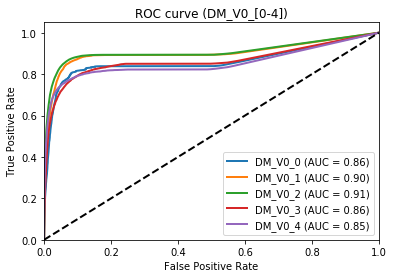

In [33]:
model_mean_fpr = {}
model_mean_tpr = {}
model_mean_th = {}
model_mean_auc = {}
for model in trained_models:
    original_data = []
    predicted_data = []

    for _, _, subject_label, _, pmap_0_label, pmap_1_label, _, _ in results[os.path.basename(model)]:
        original_data.append(nib.load(subject_label).get_data().ravel())
        predicted_data.append(nib.load(pmap_1_label).get_data().ravel())

    n = len(results[os.path.basename(model)]) # number of subjects
    fpr = {}
    tpr = {}
    th = {}
    for i in range(n):
        fpr[i], tpr[i], th[i] = roc_curve(original_data[i], predicted_data[i])
    
    # http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    mean_th = np.zeros_like(all_fpr)
    for i in range(n):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
        mean_th += interp(all_fpr, fpr[i], th[i])

    # Finally average it and compute AUC
    mean_tpr /= n
    mean_th /= n    
    
    model_mean_fpr[os.path.basename(model)] = all_fpr
    model_mean_tpr[os.path.basename(model)] = mean_tpr
    model_mean_th[os.path.basename(model)] = mean_th
    model_mean_auc[os.path.basename(model)] = auc(all_fpr, mean_tpr)

        
plt.figure()
lw = 2
for model in trained_models:
    plt.plot(model_mean_fpr[os.path.basename(model)], model_mean_tpr[os.path.basename(model)], lw=lw,
             label='{0} (AUC = {1:0.2f})'
             ''.format(os.path.basename(model), model_mean_auc[os.path.basename(model)]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve (' + model_variant + ')')
plt.legend(loc="lower right")
plt.savefig(os.path.join(root, model_name + '_roc.pdf'), bbox_inches='tight')

Load each model's metrics, compute mean and variance. This is the final result of an experiment, and determines its performance.

In [29]:
metrics = []
for model in trained_models:
    with open(os.path.join(model, 'test_metrics.pkl'), 'rb') as input:
        metrics.append(pickle.load(input))

metrics = np.array(metrics)
test_metrics['mean'] = {k : np.mean([t['mean'][k] for t in metrics]) for k in metrics[0]['mean']}
test_metrics['std'] = {k : np.std([t['std'][k] for t in metrics]) for k in metrics[0]['std']}

# Save final experiment metrics
with open(os.path.join(root, model_name + '_test_metrics.pkl'), 'wb') as output:
    pickle.dump(test_metrics, output, pickle.HIGHEST_PROTOCOL)

Plot original and predicted labels for test cases

In [ ]:
# Plot original label and predicted label on top of original image
for model in trained_models:
    
    plt.close('all')
    fig = plt.figure(figsize=(16, len(results[os.path.basename(model)])*2))
    i = 1

    for subject, subject_channels, subject_label, pred_label, _, _, _, metrics in results[os.path.basename(model)]:
        original_img = nib.load(subject_channels[0])
        original_label_img = nib.load(subject_label)
        predicted_label_img = nib.load(pred_label)
        
        ax = fig.add_subplot(len(results[os.path.basename(model)]), 2, i)
        ax.set_title('Ground truth for subject: ' + subject)
        temp = plot_roi(original_label_img, original_img, display_mode='z', cut_coords=4, figure=fig, axes=ax)
        ax = fig.add_subplot(len(results[os.path.basename(model)]), 2, i+1)
        ax.set_title('Prediction. DICE: %.2f, HD: %.2f, JI: %.2f, SEN: %.2f, SPE: %.2f.'
                             % (metrics['F1S'], metrics['HD'], metrics['JI'], metrics['TPR'], metrics['TNR']))
        plot_roi(predicted_label_img, original_img, display_mode='z', cut_coords=temp.cut_coords, figure=fig, axes=ax)
        i += 2

    plt.savefig(os.path.join(model, 'testSegResults_' + os.path.basename(model) + '.pdf'), bbox_inches='tight')

**PROCESS TRAINING AND VALIDATION RESULTS**

Plot and save training progress

In [ ]:
for model in trained_models:
    # Plot and save training progress
    os.system("python ischleseg/deepmedic/plotSaveTrainingProgress.py " +
              os.path.join(model, "output/logs/trainSession.txt -d -m 20 -s"))
    # Move files to the corresponding model directory
    os.system("mv trainingProgress.pdf " + os.path.join(model, 'trainingProgress_' + os.path.basename(model) + '.pdf'))
    os.system("mv trainingProgress.pkl " + os.path.join(model, 'trainingProgress.pkl'))


Load training metrics and compute mean and variance between models (includes training and validation metrics)

In [ ]:
# Load "measuredMetricsFromAllExperiments"
# 1st dimension: "Validation" (0), "Training" (1)
# 2nd dimension: ? (0)
# 3rd dimension: "Mean Accuracy" (0), "Sensitivity" (1), "Specificity" (2), "DSC (samples)" (3), "DSC (full-segm)" (4)

metrics = {}
for model in trained_models:
    with open(os.path.join(model, 'trainingProgress.pkl'), 'rb') as input:
        metrics[os.path.basename(model)] = np.array(pickle.load(input))
        metrics[os.path.basename(model)][0,0,4] = np.array(metrics[os.path.basename(model)][0,0,4])
        
# Compute mean and variance of all models' variations metrics
metrics_mean = {}
metrics_var = {}
metrics_values = np.array(metrics.values())
metrics_names_0 = ['Validation', 'Training']
metrics_names_1 = ['Mean Accuracy', 'Sensitivity', 'Specificity', 'DSC (Samples)', 'DSC (full-segm)']

for i in range(len(metrics_names_0)):
    metrics_mean[metrics_names_0[i]] = {}
    metrics_var[metrics_names_0[i]] = {}
    for j in range(len(metrics_names_1)):
        if i == 1 and j == 4: # Skip DSC_full for training (is never calculated)
            metrics_mean[metrics_names_0[i]][metrics_names_1[j]] = np.zeros(35*20)
            metrics_var[metrics_names_0[i]][metrics_names_1[j]] = np.zeros(35*20)
            continue 
        metrics_mean[metrics_names_0[i]][metrics_names_1[j]] = np.mean(metrics_values[:,i,0,j])
        metrics_var[metrics_names_0[i]][metrics_names_1[j]] = np.var(metrics_values[:,i,0,j])

train_val_metrics = {}
train_val_metrics['mean'] = metrics_mean
train_val_metrics['var'] = metrics_var
# Save final experiment progress metrics
with open(os.path.join(root, model_name + '_train_val_metrics.pkl'), 'wb') as output:
    pickle.dump(train_val_metrics, output, pickle.HIGHEST_PROTOCOL)

Plot mean training and validation progress metrics of all trained models

In [ ]:
metrics = []
for model in trained_models:
    with open(os.path.join(model, 'test_metrics.pkl'), 'rb') as input:
        metrics.append(pickle.load(input))

plt.close('all')
rows, cols = [2, 5]
fig = plt.figure(figsize=(cols*6, rows*4))
for i in range(len(metrics_names_0)):
    for j in range(len(metrics_names_1)):
        ax = fig.add_subplot(rows, cols, i * cols + 1 + j)
        if i == 0 and j == 4:
            plt.plot(np.arange(0, 40, 5), metrics_mean[metrics_names_0[i]][metrics_names_1[j]], 'r')
        else:            
            plt.plot(np.arange(0, 35, 1/20.0), metrics_mean[metrics_names_0[i]][metrics_names_1[j]], 'r')
        plt.xlim(0, 35)
        plt.ylim(0, 1.0)
        plt.xlabel('Epoch')
        plt.ylabel(metrics_names_0[i])
        plt.title(metrics_names_1[j])
        ax.yaxis.grid(True)

# Save mean training and validation metrics of all trained models averaged
plt.subplots_adjust(hspace=0.5)
plt.savefig(os.path.join(root, model_name + '_meanTrainProgress.pdf'), bbox_inches='tight')

In [ ]:
with open('/home/uziel/DISS/milestones_4/V0_test_metrics.pkl', 'rb') as input:
    test_metrics_V0 = pickle.load(input)
with open('/home/uziel/DISS/milestones_4/V0_transfer_test_metrics.pkl', 'rb') as input:
    test_metrics_V0_transfer = pickle.load(input)
with open('/home/uziel/DISS/milestones_4/V1_test_metrics.pkl', 'rb') as input:
    test_metrics_V1 = pickle.load(input)
with open('/home/uziel/DISS/milestones_4/V1_transfer_test_metrics.pkl', 'rb') as input:
    test_metrics_V1_transfer = pickle.load(input)
with open('/home/uziel/DISS/milestones_4/V2_test_metrics.pkl', 'rb') as input:
    test_metrics_V2 = pickle.load(input)


In [ ]:
with open('/home/uziel/DISS/milestones_4/V0_R_test_metrics.pkl', 'rb') as input:
    test_metrics_V0_R = pickle.load(input)